In [1]:
import time
from typing import Optional, Tuple, List, Dict
import colorsys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from enum import Enum

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'2.0.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:

class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str = 'cuda') -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=10,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
class Mode(Enum):
    NO_BN = 1
    BATCH_NORM_2D = 2
    GROUP_NORM_4G_2D = 3
    INSTANCE_NORM_2D = 4
    PIXEL_NORM = 5

    @staticmethod
    def modes() -> Dict[str, 'Mode']:
        return {
            'no nb': Mode.NO_BN,
            'batch norm': Mode.BATCH_NORM_2D,
            'group norm 4g': Mode.GROUP_NORM_4G_2D,
            'instance norm': Mode.INSTANCE_NORM_2D,
            'pixel norm': Mode.PIXEL_NORM,
        }

class PixelNorm(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x / ((x ** 2).sum(dim = 1, keepdims=True) / x.size(1)).sqrt()

class MyConvModel(nn.Module):
    def __init__(self, channels: int, mode: Mode):
        super().__init__()

        self.mode: Mode = mode

        c = channels
        self.layers = nn.Sequential(
            *self.conv(1, c, kernel_size=3),  # 28 - 26
            *self.conv(c, c, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            *self.conv(c, c * 2, kernel_size=3),  # 12 - 10
            *self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            *self.conv(c * 2, c * 4, kernel_size=3),  # 4 - 2
            *self.conv(c * 4, c * 4, kernel_size=2, out_one=True),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size, out_one: bool = False) -> List[nn.Module]:
        layers: List[nn.Module] = [
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=True)
        ]
        
        if self.mode == Mode.BATCH_NORM_2D:
            layers.append(nn.BatchNorm2d(num_features=out_ch))
        elif self.mode == Mode.GROUP_NORM_4G_2D:
            layers.append(nn.GroupNorm(num_groups=4, num_channels=out_ch))
        elif self.mode == Mode.INSTANCE_NORM_2D:
            if not out_one:
                layers.append(nn.InstanceNorm2d(num_features=out_ch))
        elif self.mode == Mode.PIXEL_NORM:
            layers.append(PixelNorm())    
        elif self.mode != Mode.NO_BN:
            raise ValueError(f"unexpected mode {self.mode}")
        
        layers.append(nn.LeakyReLU(0.1))
        return layers
            
    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [7]:
def run_networks(repeats: int) -> Dict[str, List[Tuple[int, int]]]:
    results = {}

    for name, mode in Mode.modes().items():        
        if name not in results:
            results[name] = []
        for i in range(repeats):
            print(f'start train network with {name}, repeat {i}')
            
            models = [MyConvModel(n, mode) for n in [8, 12, 16, 24, 32]]

            for pair in TrainHelper.train_models(models):
                results[name].append(pair)

    return results

results_bn = run_networks(repeats=4)

start train network with no nb, repeat 0
best accuracy = 0.9671, parameters = 13250, training time = 46.18888258934021
best accuracy = 0.9733, parameters = 29422, training time = 44.90635681152344
best accuracy = 0.9794, parameters = 51962, training time = 44.93871283531189
best accuracy = 0.9855, parameters = 116146, training time = 44.84745788574219
best accuracy = 0.9882, parameters = 205802, training time = 45.03482723236084
start train network with no nb, repeat 1
best accuracy = 0.9666, parameters = 13250, training time = 45.056666135787964
best accuracy = 0.9684, parameters = 29422, training time = 45.10073399543762
best accuracy = 0.9795, parameters = 51962, training time = 45.05262565612793
best accuracy = 0.9862, parameters = 116146, training time = 45.20577812194824
best accuracy = 0.9883, parameters = 205802, training time = 45.22325277328491
start train network with no nb, repeat 2
best accuracy = 0.9593, parameters = 13250, training time = 44.9990508556366
best accuracy =

/tmp/ipykernel_950390/643720575.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(params_counts, accuracies, c=color, label=name)


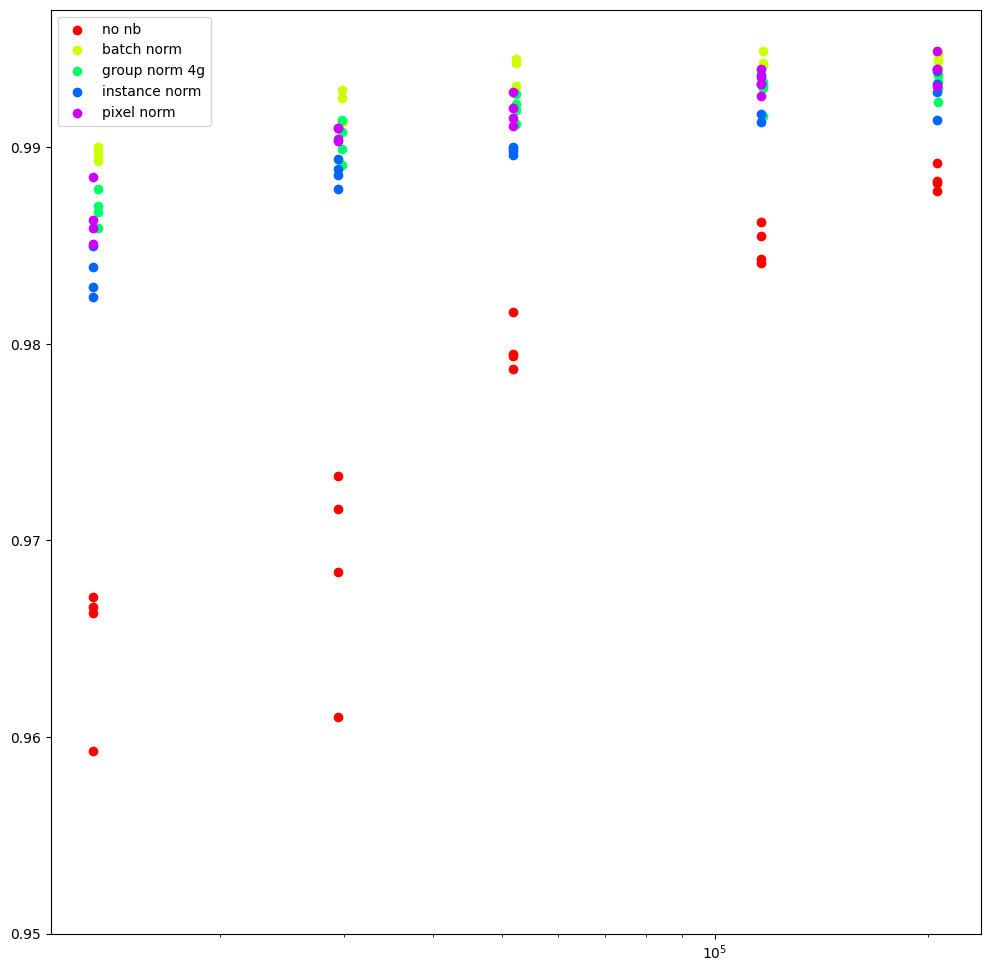

In [11]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.95, 0.997)

for i, (name, r) in enumerate(results_bn.items()):
    params_counts = [p[0] for p in r]
    accuracies = [p[1] for p in r]

    color = colorsys.hsv_to_rgb(i * 0.2, 1.0, 1.0)
    ax.scatter(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()

/tmp/ipykernel_950390/998449191.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(params_counts, accuracies, c=color, label=name)


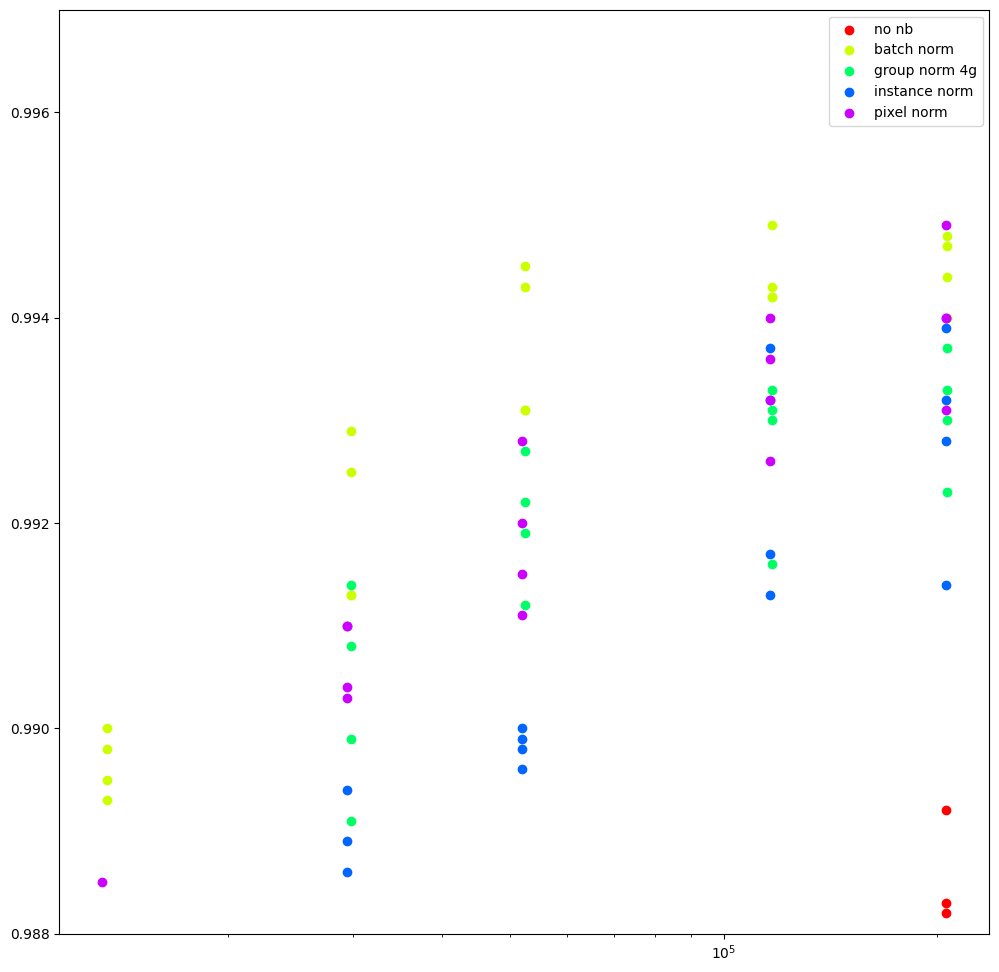

In [12]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.988, 0.997)

for i, (name, r) in enumerate(results_bn.items()):
    params_counts = [p[0] for p in r]
    accuracies = [p[1] for p in r]

    color = colorsys.hsv_to_rgb(i * 0.2, 1.0, 1.0)
    ax.scatter(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()